In [1]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np
from ta import add_all_ta_features

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Binary Classification Specific Metrics
#from sklearn.metrics import plot_roc_curve

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import statsmodels.graphics.tsaplots as sgt
# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree
from statsmodels.tsa.stattools import acf
from ta.trend import MACD


### Data Management

In [103]:
# Data Extraction
symbol = "LT.NS"

df = pd.read_csv("./stock_historical_data/{}.csv".format(symbol))
df.set_index("Date", inplace=True)

df = df[["Open", "High", "Low", "Close","Volume"]]
df["Returns"] = df["Close"].pct_change()
df["Range"] = df["High"] / df["Low"] - 1
df["Avg_Range"] = df["Range"].rolling(window=30).mean()
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Avg_Range
Date,,,,,,,,
2023-07-03,2478.199951,2492.399902,2448.000000,2454.050049,1078456,-0.008685,0.018137,0.013808
2023-07-04,2458.199951,2484.399902,2458.199951,2461.850098,1441581,0.003178,0.010658,0.013496
2023-07-05,2461.000000,2484.949951,2454.350098,2470.800049,1191896,0.003635,0.012468,0.013386
2023-07-06,2468.100098,2499.949951,2467.550049,2488.600098,1796824,0.007204,0.013130,0.013326
2023-07-07,2482.750000,2504.000000,2444.600098,2449.350098,1837661,-0.015772,0.024298,0.013688


In [104]:
#adding nifty index
dfNifty = pd.read_csv("./stock_historical_data/{}.csv".format("^NSEI"))
dfNifty.set_index("Date", inplace=True)


In [106]:
df["Nifty"] = dfNifty["Close"].pct_change()

In [107]:
df["gap"] = df["Close"].shift() - df["Open"]
df = df.dropna()
df

,Open,High,Low,Close,Volume,Returns,Range,Avg_Range,Nifty,gap
Date,,,,,,,,,,
2007-09-18,469.444075,476.676078,468.356576,474.618866,2931493,0.010750,0.017763,0.027186,0.011469,0.126909
2007-09-19,480.319290,487.569364,477.083925,483.935242,4781160,0.019629,0.021978,0.026695,0.040946,-5.700424
2007-09-20,486.663037,507.325807,484.922989,498.317566,6294343,0.029720,0.046199,0.027712,0.003212,-2.727795
2007-09-21,498.317767,508.413511,496.369280,505.051300,2783119,0.013513,0.024265,0.027183,0.018957,-0.000201
2007-09-24,505.694600,529.293695,499.423250,525.732056,5292526,0.040948,0.059810,0.027917,0.019566,-0.643300
...,...,...,...,...,...,...,...,...,...,...
2023-07-03,2478.199951,2492.399902,2448.000000,2454.050049,1078456,-0.008685,0.018137,0.013808,0.006957,-2.649902
2023-07-04,2458.199951,2484.399902,2458.199951,2461.850098,1441581,0.003178,0.010658,0.013496,0.003439,-4.149902
2023-07-05,2461.000000,2484.949951,2454.350098,2470.800049,1191896,0.003635,0.012468,0.013386,0.000490,0.850098


In [36]:
#df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
#df = df.dropna()
#df.head()

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/wrapper.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{colprefix}volume_adi"] = AccDistIndexIndicator(
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/wrapper.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{colprefix}volume_obv"] = OnBalanceVolumeIndicator(
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/wrapper.py:101: SettingWithCopyWarning: 
A value is trying to be set 

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/wrapper.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{colprefix}trend_cci"] = CCIIndicator(
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/wrapper.py:367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{colprefix}trend_visual_ichimoku_a"] = indicator_ichi_visual.ichimoku_a()
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/wrapper.py:368: SettingWithCopyWarning: 
A value is try

,Open,High,Low,Close,Volume,Returns,Range,Avg_Range,TARGET,Nifty,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2007-09-18,469.444075,476.676078,468.356576,474.618866,2931493,0.010750,0.017763,0.027186,0.0,0.011469,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,474.618866,-50.160266,0.000000,0.000000
2007-09-19,480.319290,487.569364,477.083925,483.935242,4781160,0.019629,0.021978,0.026695,1.0,0.040946,...,0.156359,0.031272,0.125087,4.808588,0.961718,3.846870,478.425566,1.962917,1.943901,1.962917
2007-09-20,486.663037,507.325807,484.922989,498.317566,6294343,0.029720,0.046199,0.027712,0.0,0.003212,...,0.516609,0.128339,0.388270,11.555203,3.080415,8.474788,486.419127,2.971952,2.928646,4.993206
2007-09-21,498.317767,508.413511,496.369280,505.051300,2783119,0.013513,0.024265,0.027183,1.0,0.018957,...,0.902089,0.283089,0.619000,8.613992,4.187130,4.426862,493.813780,1.351294,1.342245,6.411973
2007-09-24,505.694600,529.293695,499.423250,525.732056,5292526,0.040948,0.059810,0.027917,1.0,0.019566,...,1.528902,0.532252,0.996650,11.691941,5.688092,6.003849,507.054275,4.094783,4.013167,10.769313


In [108]:
# Specify Target
df.loc[df["Range"].shift(-1) > df["Avg_Range"], "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["Avg_Range"], "TARGET"] = 0

In [109]:
# Fill NA
df["TARGET"].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Avg_Range,Nifty,gap,TARGET
Date,,,,,,,,,,,
2023-07-03,2478.199951,2492.399902,2448.000000,2454.050049,1078456,-0.008685,0.018137,0.013808,0.006957,-2.649902,0.0
2023-07-04,2458.199951,2484.399902,2458.199951,2461.850098,1441581,0.003178,0.010658,0.013496,0.003439,-4.149902,0.0
2023-07-05,2461.000000,2484.949951,2454.350098,2470.800049,1191896,0.003635,0.012468,0.013386,0.000490,0.850098,0.0
2023-07-06,2468.100098,2499.949951,2467.550049,2488.600098,1796824,0.007204,0.013130,0.013326,0.005093,2.699951,1.0
2023-07-07,2482.750000,2504.000000,2444.600098,2449.350098,1837661,-0.015772,0.024298,0.013688,-0.008488,5.850098,0.0


### Train Test Split

In [110]:
# Split into X and Y Data
X = df.iloc[:, : -1]
y = df.iloc[:, -1]

In [111]:
# Perform Train Test Split (Timeseries based method)
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (2711, 10)
Shape of y_train:  (2711,)
Shape of X_test:  (1162, 10)
Shape of y_test:  (1162,)
Size Matches:  True


### Build Model

In [112]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [113]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [114]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [115]:
# Hyperparams: ne: 80, lr: 0.01 md: 3 gm: 6
# ne: 1#15, lr: 0.2 md: 5 gm: 20
#Recommended Params >> ne: 65, lr: 0.05 md: 1 gm: 20

ne = 65
lr = 0.05
md = 1
gm = 20

In [116]:
# XGBOOST Classifier
classifier = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [117]:
# Fit Model
eval_set = [(X_train, y_train), (X_test, y_test)]
classifier.set_params(eval_metric=eval_metric_list)  # Example metric: 'error'

classifier.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'logloss'], feature_types=None,
              gamma=20, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=65, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

### Make Predictions

In [118]:
# Get Predictions Training
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)
print("Preds Training Data: \n", train_yhat[:10])
print("Preds Probabilities Training Data: \n", train_yhat_proba[:3])

Preds Training Data: 
 [0 0 0 0 0 0 0 0 0 0]
Preds Probabilities Training Data: 
 [[0.6359241  0.36407593]
 [0.6359241  0.36407593]
 [0.55950975 0.44049025]]


In [119]:
# Get Predictions Test
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)
print("Preds Test Data: \n", test_yhat[:10])
print("Preds Probabilities Training Data: \n", test_yhat_proba[:3])

Preds Test Data: 
 [0 0 0 0 0 0 0 0 0 0]
Preds Probabilities Training Data: 
 [[0.64147985 0.35852018]
 [0.6359241  0.36407593]
 [0.64147985 0.35852018]]


In [120]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [121]:
# Training Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  w

### Evaluation Metrics  - Loss and Overfitting

In [122]:
# Retrieve performance metrics
results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

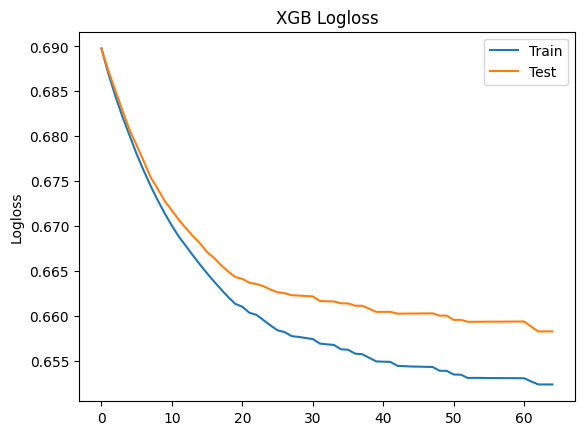

In [123]:
# Plot Log Loss
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Logloss")
plt.title("XGB Logloss")
plt.show()

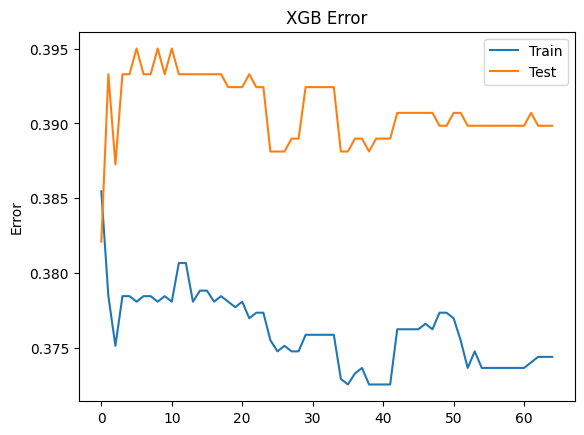

In [124]:
# Plot Classification Error
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Error")
plt.title("XGB Error")
plt.show()

### Evaluation Metrics - ROC Curve

In [22]:
# Plot Training ROC Curve
#plot_roc_curve(classifier, X_train, y_train)

In [23]:
# Plot Test ROC Curve
#plot_roc_curve(classifier, X_test, y_test)

### Performance Evaluation Comparison

In [125]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [126]:
# Training and Test Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
test_results = cross_val_score(classifier, X_test, y_test, scoring=scoring, cv=cv, n_jobs=-1)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behav

In [127]:
# Comparison of Results
print("TRAIN:")
print("Average Acc K-Fold", round(train_results.mean(), 2))
print("Std Dev K-Fold", round(train_results.std(), 2))
print("Precision Score 0", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("----- ----- ----- ----- ----- ----- -----")
print("TEST:")
print("Average Acc K-Fold", round(test_results.mean(), 2))
print("Std Dev K-Fold", round(test_results.std(), 2))
print("Precision Score 0", round(precision_score(y_test, test_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_test, test_yhat, average=None)[1], 3))
print("")

TRAIN:
Average Acc K-Fold 0.62
Std Dev K-Fold 0.09
Precision Score 0 0.622
Precision Score 1 0.686
----- ----- ----- ----- ----- ----- -----
TEST:
Average Acc K-Fold 0.35
Std Dev K-Fold 0.44
Precision Score 0 0.61
Precision Score 1 0.633



### Evaluation Metrics - Summary Report

In [128]:
# Show summary report - Training
print(classification_report(y_train, train_yhat))

              precision    recall  f1-score   support

         0.0       0.62      0.97      0.76      1639
         1.0       0.69      0.10      0.17      1072

    accuracy                           0.63      2711
   macro avg       0.65      0.53      0.46      2711
weighted avg       0.65      0.63      0.53      2711



In [129]:
# Show summary report - Test
print(classification_report(y_test, test_yhat))

              precision    recall  f1-score   support

         0.0       0.61      0.98      0.75       701
         1.0       0.63      0.04      0.08       461

    accuracy                           0.61      1162
   macro avg       0.62      0.51      0.42      1162
weighted avg       0.62      0.61      0.48      1162



### Performance Evaluation - Confusion Matrix

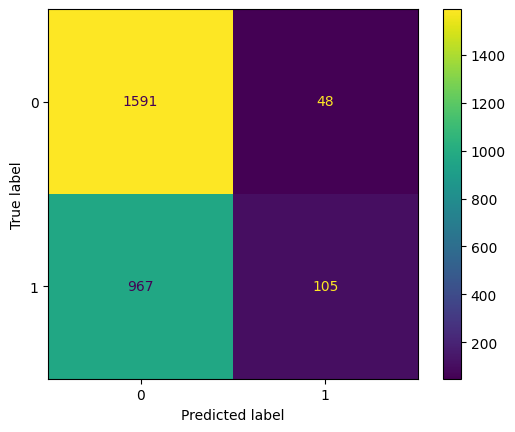

In [130]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_yhat)
ConfusionMatrixDisplay(cm_train).plot()

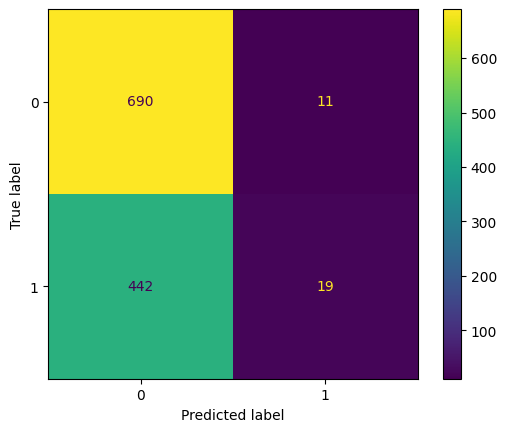

In [131]:
# Test Confusion Matrix
cm_test = confusion_matrix(y_test, test_yhat)
ConfusionMatrixDisplay(cm_test).plot()

### Feature Importance

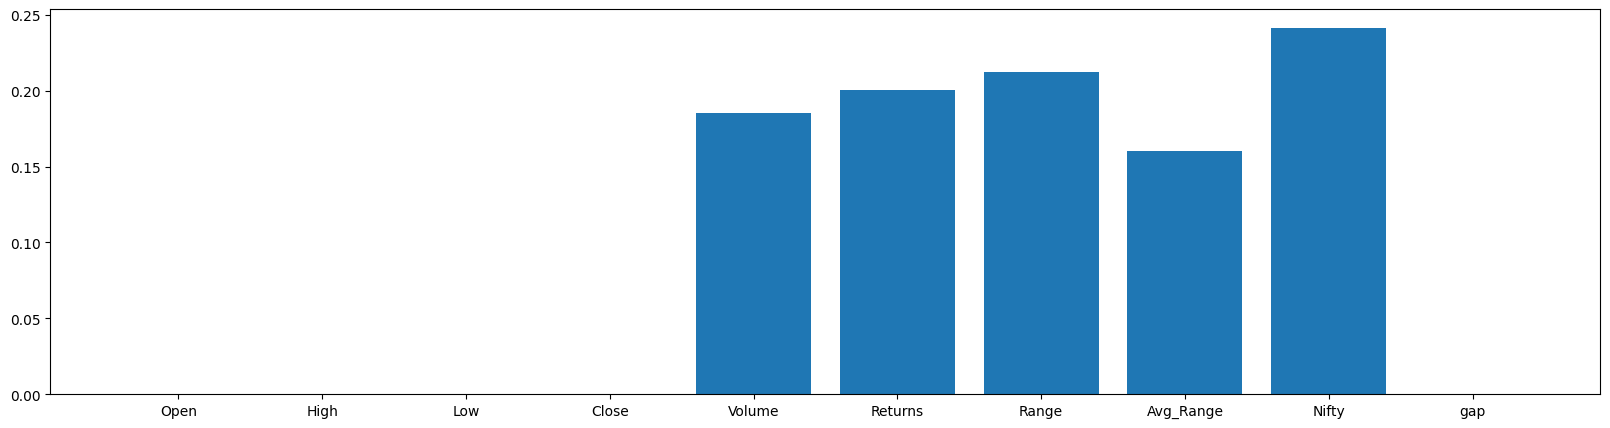

In [132]:
# Plot Feature Importances
fig = plt.figure(figsize=(20, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_

plt.bar(importance_labels, importance_features)
plt.show()

In [38]:
filtered_numbers = []
filterd_labels = []
filter_score = []
for index,ddd in enumerate(importance_features):
    if ddd > 0.05:
        filter_score.append(ddd)
        filterd_labels.append(importance_labels[index])
       # print(importance_labels[index])
print(filterd_labels)

['Returns', 'Range', 'Avg_Range', 'volatility_bbp', 'volatility_kcp', 'trend_mass_index', 'trend_adx_pos', 'momentum_rsi', 'momentum_roc', 'momentum_pvo', 'momentum_pvo_hist']


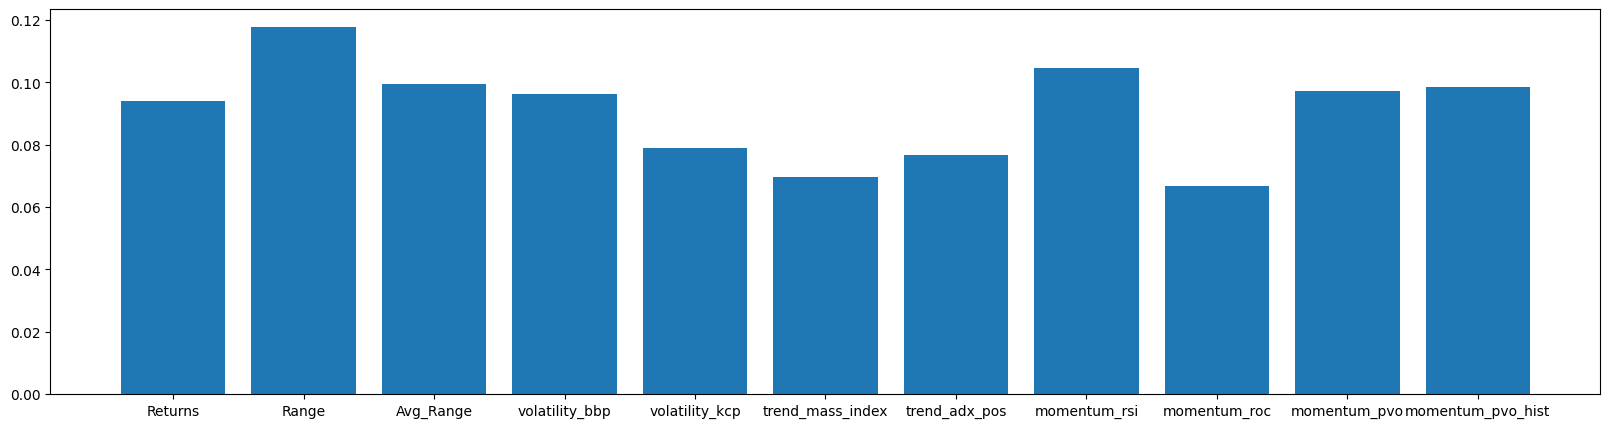

In [39]:
# Plot Feature Importances
fig = plt.figure(figsize=(20, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_

plt.bar(filterd_labels, filter_score)
plt.show()

In [32]:
#conda install graphviz python-graphviz

### XGBOOST TREE

<Axes: >

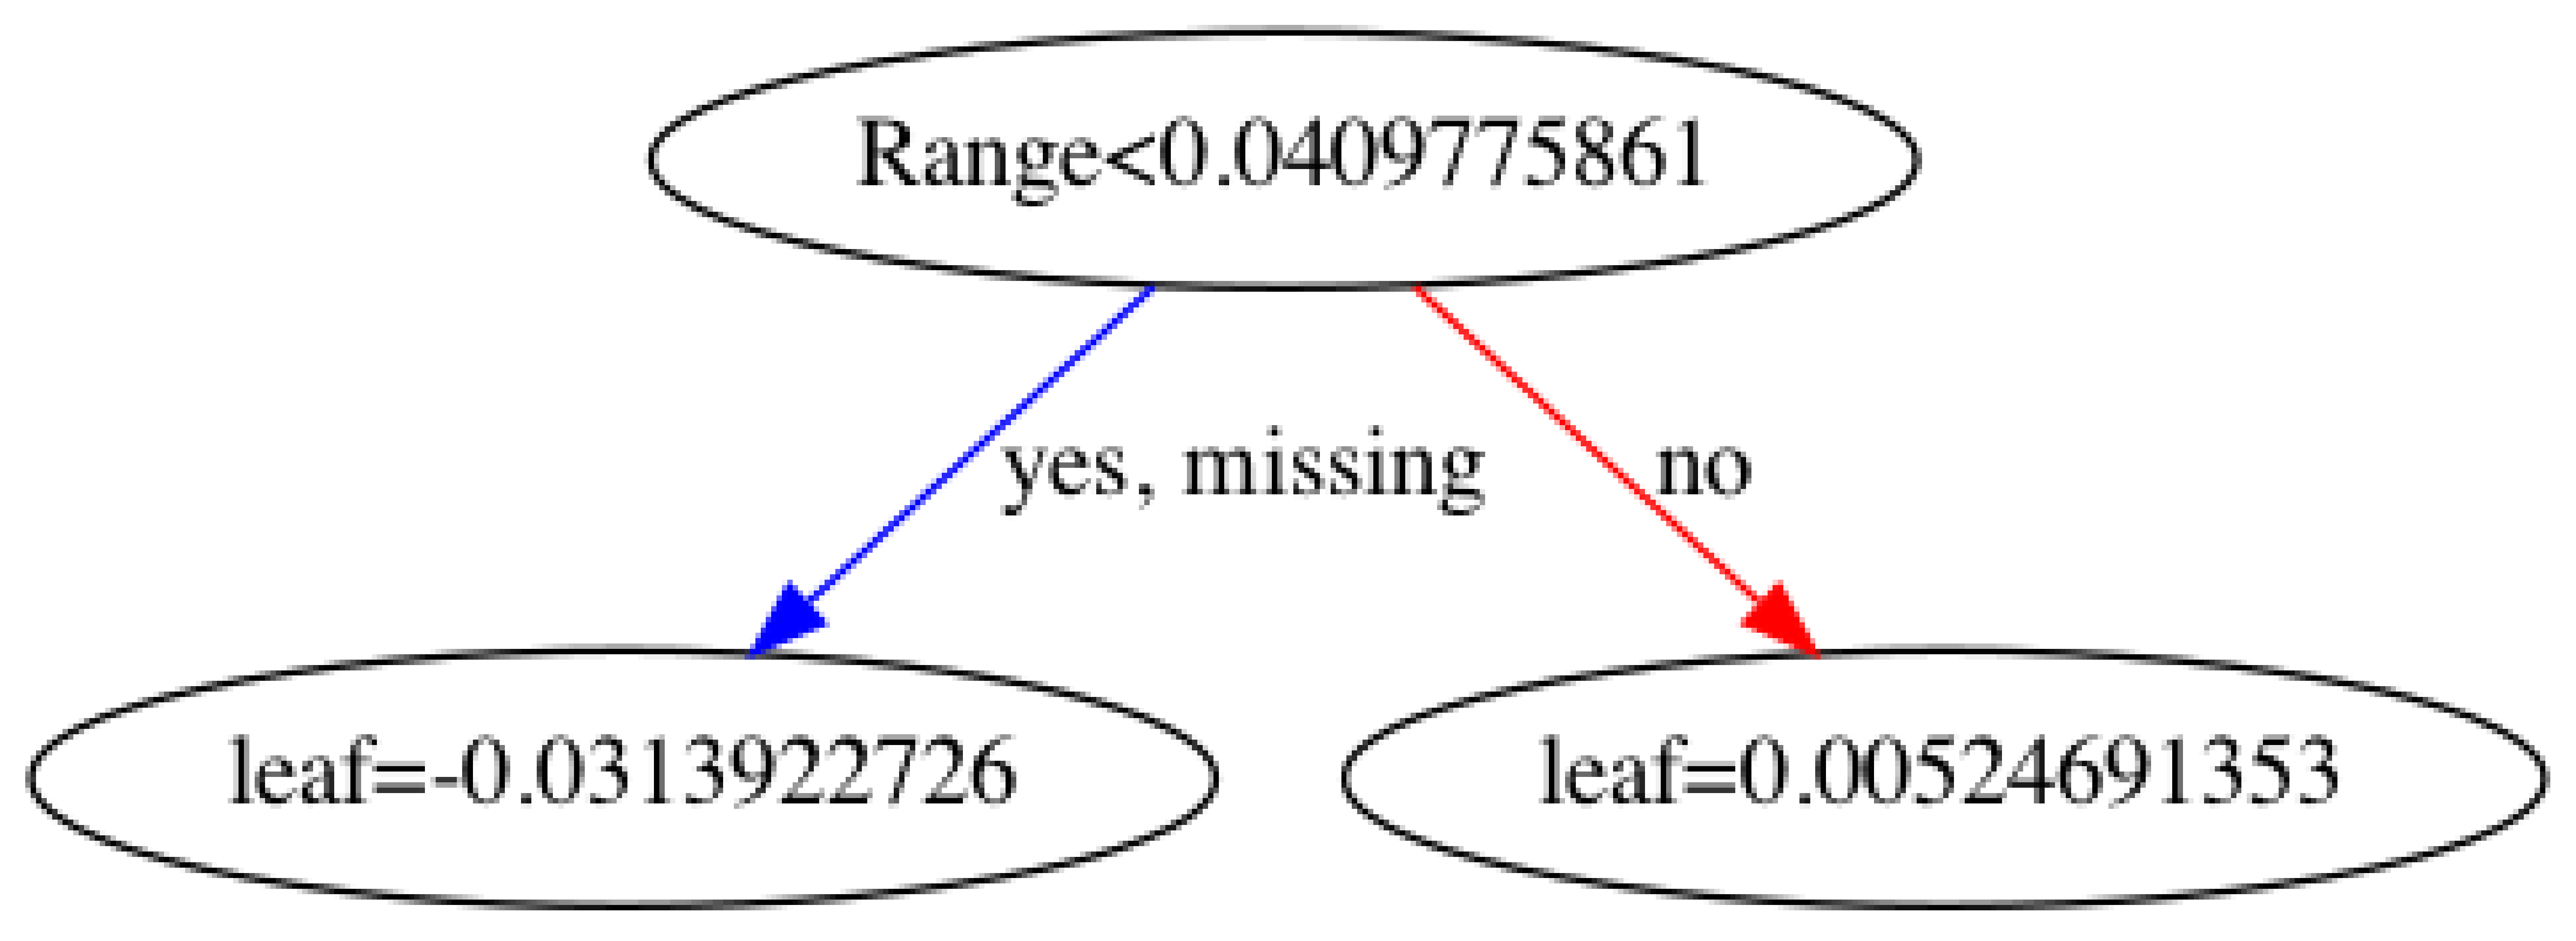

In [40]:
rcParams["figure.figsize"] = 80, 50
plot_tree(classifier)

### Conclusion

We feel that it is possible using Machine Learning, that we can forecast with better than 50/50 odds, whether the Range (our interpretation of volatility) for Bitcoin, can be predicted ahead of of time by at least 1 day into the future. This information could be valuable for MOVE based contracts trading.